In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np
from joblib import dump

# Load the dataset
file_path = 'S:/ML Course/Capstone 1/mxmh_survey_results.csv'
mxmh_data = pd.read_csv(file_path)

# Data Overview
print("Data Overview:")
print(mxmh_data.info())

# Separate features and the target variable before dropping non-feature columns
y = mxmh_data['Age']

# Drop non-feature columns
mxmh_data = mxmh_data.drop(columns=['Timestamp', 'Permissions', 'Age'], errors='ignore')

# Separate features and the target variable
X = mxmh_data

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 736 entries, 0 to 735
Data columns (total 33 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Timestamp                     736 non-null    object 
 1   Age                           735 non-null    float64
 2   Primary streaming service     735 non-null    object 
 3   Hours per day                 736 non-null    float64
 4   While working                 733 non-null    object 
 5   Instrumentalist               732 non-null    object 
 6   Composer                      735 non-null    object 
 7   Fav genre                     736 non-null    object 
 8   Exploratory                   736 non-null    object 
 9   Foreign languages             732 non-null    object 
 10  BPM                           629 non-null    float64
 11  Frequency [Classical]         736 non-null    object 
 12  Frequency [Country]           736 non-null    obj

In [41]:
# Statistical Summary
print("\nStatistical Summary:")
descriptive_stats = mxmh_data.describe()
print(descriptive_stats)


Statistical Summary:
       Hours per day           BPM     Anxiety  Depression    Insomnia  \
count     736.000000  6.290000e+02  736.000000  736.000000  736.000000   
mean        3.572758  1.589948e+06    5.837636    4.796196    3.738451   
std         3.028199  3.987261e+07    2.793054    3.028870    3.088689   
min         0.000000  0.000000e+00    0.000000    0.000000    0.000000   
25%         2.000000  1.000000e+02    4.000000    2.000000    1.000000   
50%         3.000000  1.200000e+02    6.000000    5.000000    3.000000   
75%         5.000000  1.440000e+02    8.000000    7.000000    6.000000   
max        24.000000  1.000000e+09   10.000000   10.000000   10.000000   

              OCD  
count  736.000000  
mean     2.637228  
std      2.842017  
min      0.000000  
25%      0.000000  
50%      2.000000  
75%      5.000000  
max     10.000000  


In [42]:
# Inspect the columns related to frequency of music genres and psychological factors
music_genre_columns = [col for col in mxmh_data.columns if 'Frequency' in col]
psychological_factors_columns = ['Anxiety', 'Depression', 'Insomnia', 'OCD']

# Create a new DataFrame with just the relevant columns for correlation analysis
analysis_data = mxmh_data[music_genre_columns + psychological_factors_columns]

# Check the data types and unique values for the music genre columns to see how they are encoded
music_genre_data_types = analysis_data[music_genre_columns].dtypes
music_genre_unique_values = {col: analysis_data[col].unique() for col in music_genre_columns}

(music_genre_data_types, music_genre_unique_values)

# Mapping for converting categorical frequency data to numerical
frequency_mapping = {
    'Never': 0,
    'Rarely': 1,
    'Sometimes': 2,
    'Very frequently': 3
}

# Apply the mapping to the music genre columns
for col in music_genre_columns:
    analysis_data.loc[:, col] = analysis_data[col].map(frequency_mapping)


# Now, calculate the correlation matrix for the relevant columns
correlation_matrix = analysis_data.corr()

# Display the correlation matrix for the psychological factors and music genres
psychological_factors_correlation = correlation_matrix[psychological_factors_columns].loc[music_genre_columns]
psychological_factors_correlation

,Anxiety,Depression,Insomnia,OCD
Frequency [Classical],-0.047259,-0.008253,0.076474,-0.007941
Frequency [Country],-0.009375,-0.043484,-0.051349,0.059096
Frequency [EDM],0.042847,0.090776,0.081871,0.099119
Frequency [Folk],0.092154,0.112735,0.043793,0.028344
Frequency [Gospel],-0.038104,-0.018077,0.003451,0.012583
Frequency [Hip hop],0.023114,0.098920,0.018582,0.045090
Frequency [Jazz],0.002204,0.052682,0.034135,-0.022568
Frequency [K pop],0.032948,-0.012201,0.008124,0.024944
Frequency [Latin],-0.008970,0.034339,0.052427,-0.016245
Frequency [Lofi],0.078485,0.043346,0.064956,0.059212


In [43]:
# Calculate the mean frequency scores for each music genre to determine popularity
genre_popularity = analysis_data[music_genre_columns].mean().sort_values(ascending=False)

genre_popularity

Frequency [Rock]                2.070652
Frequency [Pop]                  2.03125
Frequency [Hip hop]             1.384511
Frequency [Classical]           1.335598
Frequency [Rap]                 1.335598
Frequency [R&B]                 1.259511
Frequency [Video game music]        1.25
Frequency [Metal]               1.220109
Frequency [Lofi]                1.067935
Frequency [Jazz]                1.027174
Frequency [EDM]                 1.023098
Frequency [Folk]                1.012228
Frequency [Country]             0.817935
Frequency [K pop]               0.735054
Frequency [Latin]               0.607337
Frequency [Gospel]              0.381793
dtype: object

In [44]:
# Missing Values Analysis
print("\nMissing Values Analysis:")
missing_values = mxmh_data.isnull().sum()
print(missing_values)


Missing Values Analysis:
Primary streaming service         1
Hours per day                     0
While working                     3
Instrumentalist                   4
Composer                          1
Fav genre                         0
Exploratory                       0
Foreign languages                 4
BPM                             107
Frequency [Classical]             0
Frequency [Country]               0
Frequency [EDM]                   0
Frequency [Folk]                  0
Frequency [Gospel]                0
Frequency [Hip hop]               0
Frequency [Jazz]                  0
Frequency [K pop]                 0
Frequency [Latin]                 0
Frequency [Lofi]                  0
Frequency [Metal]                 0
Frequency [Pop]                   0
Frequency [R&B]                   0
Frequency [Rap]                   0
Frequency [Rock]                  0
Frequency [Video game music]      0
Anxiety                           0
Depression                        0
In

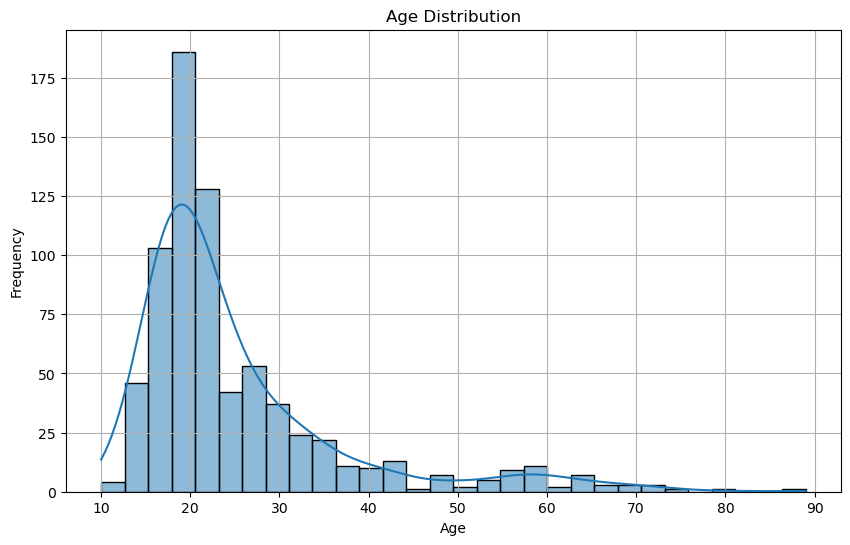

In [45]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(y, bins=30, kde=True)  # Use 'y' instead of mxmh_data['Age']
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

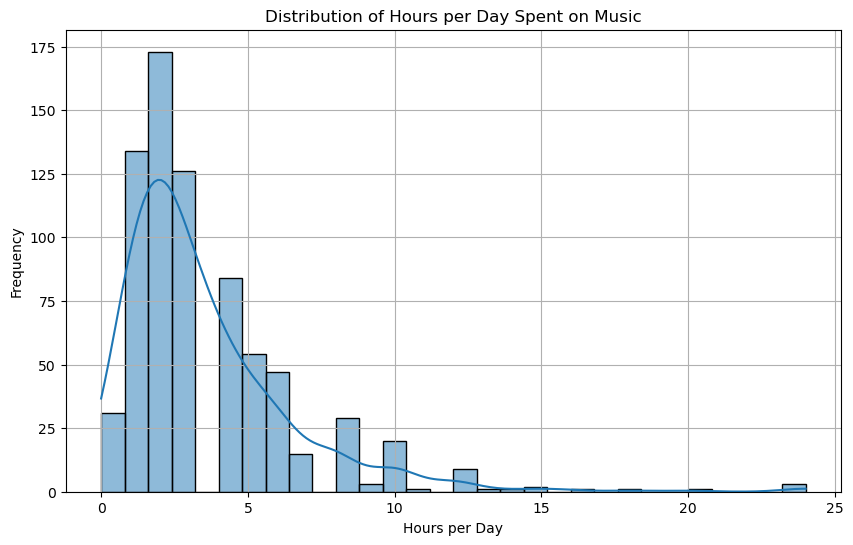

In [46]:
# Hours per day spent on music
plt.figure(figsize=(10, 6))
sns.histplot(mxmh_data['Hours per day'], bins=30, kde=True)
plt.title('Distribution of Hours per Day Spent on Music')
plt.xlabel('Hours per Day')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

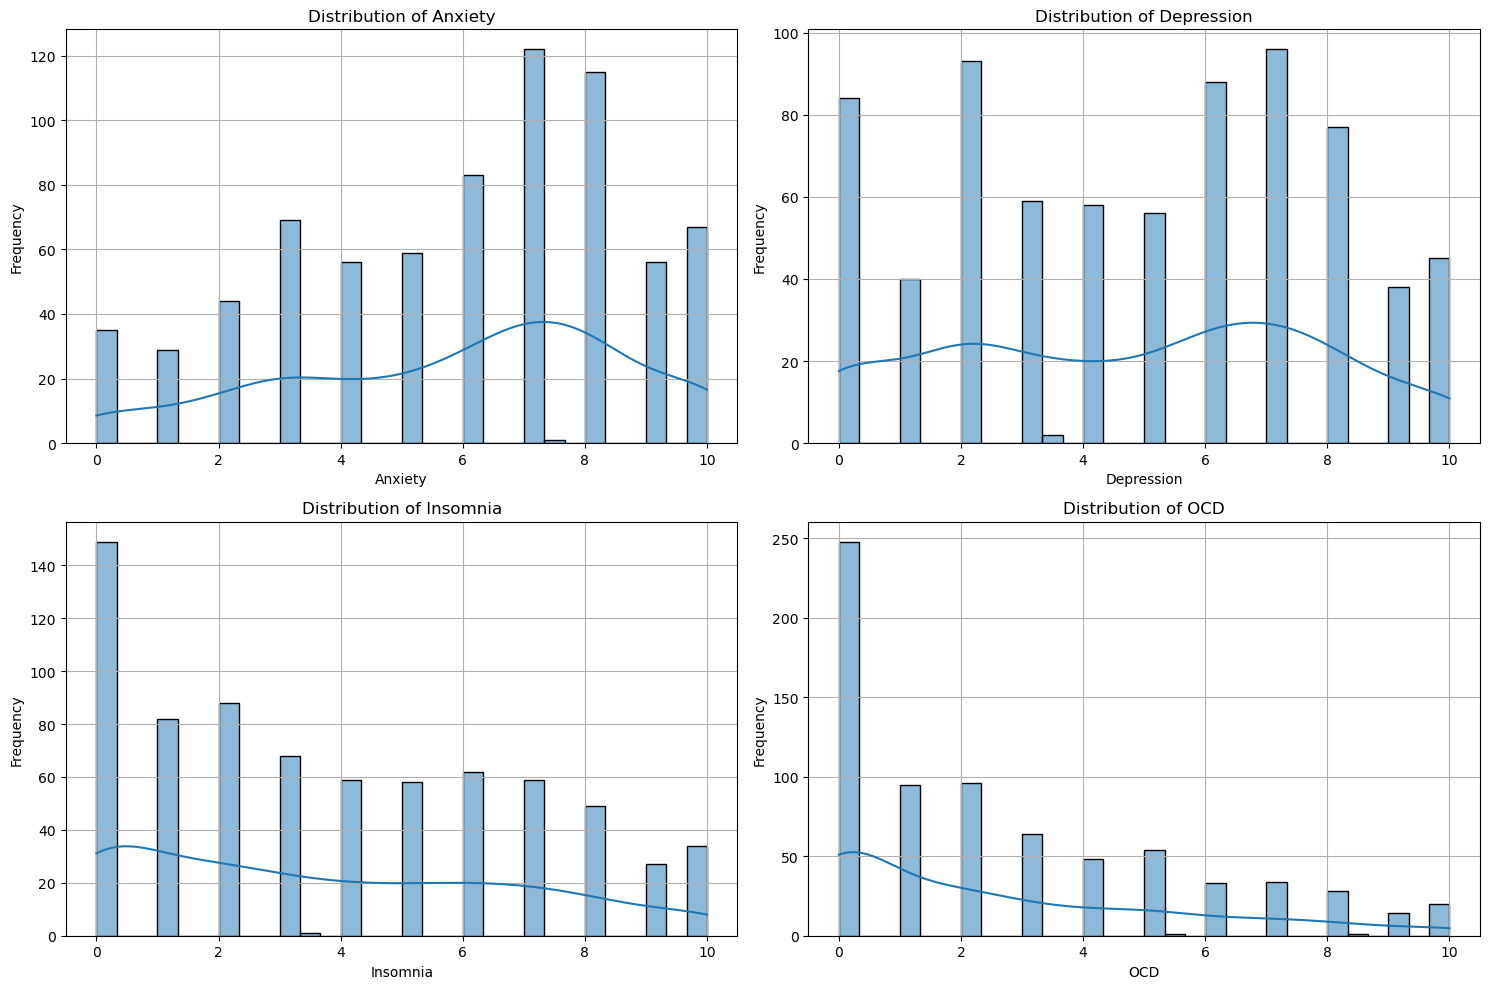

In [47]:
# Mental health indicators distributions
mental_health_columns = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
plt.figure(figsize=(15, 10))
for i, col in enumerate(mental_health_columns):
    plt.subplot(2, 2, i+1)
    sns.histplot(mxmh_data[col], bins=30, kde=True)
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [50]:
# Reloading the csv
mxmh_data = pd.read_csv('S:/ML Course/Capstone 1/mxmh_survey_results.csv')

# Define transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])


# Fill NaN values with the mean of the 'Age' column
mxmh_data['Age'] = mxmh_data['Age'].fillna(mxmh_data['Age'].mean())

# Extract the target variable 'Age' before dropping it from the features DataFrame
y = mxmh_data['Age']
X = mxmh_data.drop(columns=['Age'])

# Define categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Define transformers
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the preprocessing pipeline for both numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Create a Linear Regression pipeline
linear_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                  ('regressor', LinearRegression())])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the Linear Regression pipeline
linear_pipeline.fit(X_train, y_train)

# Predict and evaluate the Linear Regression model
y_pred = linear_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Linear Regression Model MSE: {mse}')

Linear Regression Model MSE: 164.50289072971862


In [51]:
# Define categorical and numerical columns
categorical_cols = mxmh_data.select_dtypes(include=['object']).columns
numerical_cols = mxmh_data.select_dtypes(include=['float64', 'int64']).columns
numerical_cols = numerical_cols.drop('Anxiety')  # Assuming 'Anxiety' is the target

# Imputing and encoding in a pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the target variable
y = mxmh_data['Anxiety'].values  # Replace 'Anxiety' with your target variable

# Split the dataset into features and target variable, and then into training and testing sets
X = mxmh_data.drop(columns=['Anxiety'])  # Drop the target variable to isolate features
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create preprocessing and training pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', RandomForestRegressor(random_state=42))])

# Define a hyperparameter grid
param_grid = {
    'regressor__n_estimators': [100, 200],
    'regressor__max_depth': [None, 10, 20],
    'regressor__min_samples_split': [2, 5]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=3)

# Execute the grid search
grid_search.fit(X_train, y_train)

# Best parameters and best score
print(f'Best parameters: {grid_search.best_params_}')
best_mse = -grid_search.best_score_
print(f'Best model performance (MSE): {best_mse}')

# Predict and evaluate with the best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Test Mean Squared Error: {mse}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-5.113 total time=   4.3s
[CV 2/5] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-6.117 total time=   3.8s
[CV 3/5] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-4.475 total time=   3.8s
[CV 4/5] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-5.607 total time=   3.8s
[CV 5/5] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=100;, score=-4.945 total time=   3.8s
[CV 1/5] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200;, score=-5.115 total time=   7.8s
[CV 2/5] END regressor__max_depth=None, regressor__min_samples_split=2, regressor__n_estimators=200;, score=-5.925 total time=   7.8s
[

In [3]:
from flask import Flask, request, jsonify
from joblib import load
from threading import Thread

app = Flask(__name__)

# Load the trained model
model = load('model.joblib')

@app.route('/')
def home():
    return "Welcome to the model prediction service!"

@app.route('/predict', methods=['POST'])
def predict():
    data = request.get_json(force=True)
    # Preprocess the input data as required, similar to how you did in the notebook
    # For example, if you expect a single feature called 'feature_input'
    input_data = [data['feature_input']]
    # Use the model to make a prediction
    prediction = model.predict([input_data])
    return jsonify({'prediction': prediction.tolist()})

# Define the function that will run the Flask app
def run_app():
    # Set the threaded argument to True to handle each request in a separate thread.
    app.run(port=6969, debug=True, use_reloader=False, threaded=True)

# Run the Flask app in a separate thread to avoid blocking the notebook
flask_thread = Thread(target=run_app)
flask_thread.start()

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:6969
Press CTRL+C to quit
